# 1. Imports and setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pathlib
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50

import itertools

### step 0 : check GPU

In [2]:
# check GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### step 1 : load dataset

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
for dirpath, dirnames, filenames in os.walk("kaggle/input"):
    print(f"{len(dirnames)} dirs and {len(filenames)} images in '{dirpath}'")

1 dirs and 0 images in 'kaggle/input'
1 dirs and 0 images in 'kaggle/input\alzheimer-mri-dataset'
4 dirs and 0 images in 'kaggle/input\alzheimer-mri-dataset\Dataset'
0 dirs and 896 images in 'kaggle/input\alzheimer-mri-dataset\Dataset\Mild_Demented'
0 dirs and 64 images in 'kaggle/input\alzheimer-mri-dataset\Dataset\Moderate_Demented'
0 dirs and 3200 images in 'kaggle/input\alzheimer-mri-dataset\Dataset\Non_Demented'
0 dirs and 2240 images in 'kaggle/input\alzheimer-mri-dataset\Dataset\Very_Mild_Demented'


In [4]:
data_dir = "kaggle/input/alzheimer-mri-dataset/Dataset/"
path_dir = pathlib.Path("kaggle/input/alzheimer-mri-dataset/Dataset/") 
class_names = np.array(sorted([item.name for item in path_dir.glob('*')]))
print(class_names)

['Mild_Demented' 'Moderate_Demented' 'Non_Demented' 'Very_Mild_Demented']


# 2. Explore individual images

In [5]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}")
    return img

Image shape: (128, 128)


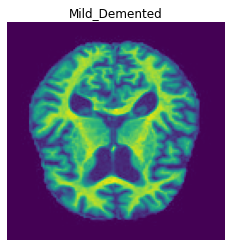

In [6]:
img = view_random_image(data_dir, class_names[0])

Image shape: (128, 128)


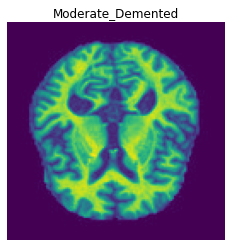

In [7]:
img = view_random_image(data_dir, class_names[1])

Image shape: (128, 128)


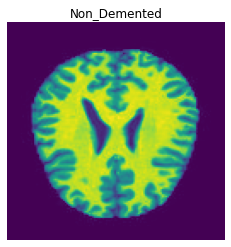

In [8]:
img = view_random_image(data_dir, class_names[2])

Image shape: (128, 128)


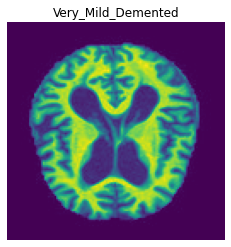

In [9]:
img = view_random_image(data_dir, class_names[3])

# 3. Model Tuning

## Split and preprocess data

In [25]:
# For replicable results
SEED = 0
# Size of the images is (128,128)
IMAGE_SIZE = (128, 128)
# Default batch size
BATCH_SIZE = 16
# Images are grayscale
COLOR_MODE = "grayscale"
# 20% test split
VAL_SPLIT = 0.2

tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    label_mode='categorical',
    seed=SEED,
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Model creation and compilation (ResNet50)

In [26]:
# cannot use the imagenet weights whith single channel images.
net = ResNet50(include_top=False, # 是否包含最後的全連接層 (fully-connected layer)
                weights=None, # None: 權重隨機初始化、'imagenet': 載入預訓練權重
               input_shape=(IMAGE_SIZE+(1,)))
x = net.layers[-1].output # 因為 include_top=False ，模型需要補上 output layer
x = Flatten(name='flatten')(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(len(class_names), activation='softmax', name='softmax')(x)

model = Model(inputs=net.input, outputs=output_layer)

In [27]:
# Default Learning rate
LR = 1e-4

model.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=["accuracy"])

## Fit and evaluate model

In [28]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_accuracy:.2f}.h5'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

# Epochs
EPOCHS = 50
history = model.fit(train_data,
                      validation_data=valid_data,
                      epochs=EPOCHS,
                      callbacks=[cp_callback])

Epoch 1/50
320/320 [==============================] - 35s 111ms/step - loss: 2.7337 - accuracy: 0.4383 - val_loss: 1.8478 - val_accuracy: 0.3609
Epoch 2/50
320/320 [==============================] - 35s 109ms/step - loss: 2.3533 - accuracy: 0.4867 - val_loss: 1.5841 - val_accuracy: 0.4938
Epoch 3/50
320/320 [==============================] - 34s 108ms/step - loss: 2.0894 - accuracy: 0.5227 - val_loss: 14.5459 - val_accuracy: 0.4289
Epoch 4/50
320/320 [==============================] - 35s 110ms/step - loss: 1.7941 - accuracy: 0.5594 - val_loss: 1.7109 - val_accuracy: 0.5352
Epoch 5/50
320/320 [==============================] - 34s 107ms/step - loss: 1.6252 - accuracy: 0.6014 - val_loss: 3.7461 - val_accuracy: 0.4906
Epoch 6/50
320/320 [==============================] - 35s 110ms/step - loss: 1.2407 - accuracy: 0.6258 - val_loss: 1.1699 - val_accuracy: 0.6477
Epoch 7/50
320/320 [==============================] - 34s 108ms/step - loss: 0.8643 - accuracy: 0.6998 - val_loss: 0.8934 - val_a

<AxesSubplot:>

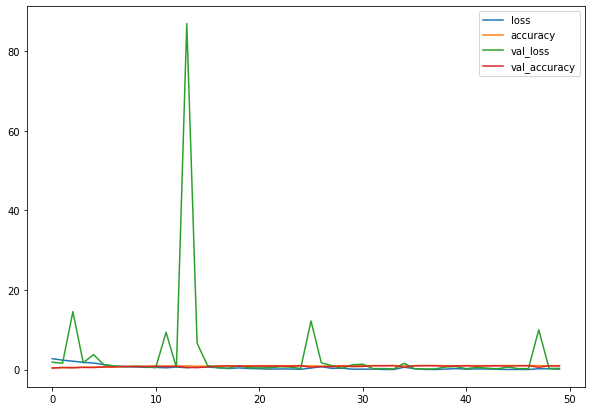

In [29]:
pd.DataFrame(history.history).plot(figsize=(10, 7))

load the weights from the checkpoint and re-evaluate:

In [30]:
# Loads the weights
weight_path = "best_weight.h5"
model.load_weights(weight_path)

# Re-evaluate the model
loss, acc = model.evaluate(valid_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

80/80 - 3s - loss: 0.1352 - accuracy: 0.9703
Restored model, accuracy: 97.03%
